# Parareal Example

## Helper Functions

In [11]:
import xml.etree.ElementTree as ET
from xml.dom import minidom
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

class Precursor:
    def __init__(self, decay_constant, beta):
        self.decay_constant = decay_constant
        self.beta = beta
        
class Precomp:
    def __init__(self, time, power, pow_norm, rho, concentrations):
        self.time = time
        self.power = power
        self.pow_norm = pow_norm
        self.rho  = rho
        self.concentrations = concentrations
        
    def set_solve_time(self, solve_time):
        self.solve_time = solve_time
        
class Params:
    def __init__(self, time=None, rho_imp=None, precursors=None, lambda_h=None, 
                 gen_time=None, pow_norm=None, beta_eff=None, 
                 theta=None, gamma_d=None, eta=None, max_iter=1,
                 n_fine_per_coarse = 1):
        self.time = time
        self.rho_imp = rho_imp
        self.precursors = precursors
        self.lambda_h = lambda_h
        self.gen_time = gen_time
        self.pow_norm = pow_norm
        self.beta_eff = beta_eff
        self.theta = theta
        self.gamma_d = gamma_d
        self.eta = eta
        self.max_iter = max_iter
        self.n_fine_per_coarse = n_fine_per_coarse
        
def write_input_xml(precomp, params):
    parareal = ET.Element("parareal", 
                          outpath="examples/epke_output.xml", 
                          max_iterations=str(params.max_iter), 
                          n_fine_per_coarse=str(params.n_fine_per_coarse))
    
    # epke precomputed values (initial conditions)
    epke_output = ET.SubElement(parareal,"epke_output", 
                                n_steps=str(len(params.time)), 
                                n_start=str(1),
                                n_stop=str(len(params.time)))
    ET.SubElement(epke_output, "time").text = ' '.join(map(str,precomp.time))
    ET.SubElement(epke_output, "power").text = ' '.join(map(str,precomp.power))
    ET.SubElement(epke_output, "pow_norm").text = ' '.join(map(str, precomp.pow_norm))
    ET.SubElement(epke_output, "rho").text = ' '.join(map(str,precomp.rho))
    concentrations_element = ET.SubElement(epke_output, "concentrations")
    
    # epke parameters
    epke_input = ET.SubElement(parareal,"epke_input", 
                               n_steps=str(len(params.time)), 
                               theta=str(params.theta), 
                               gamma_d=str(params.gamma_d),
                               eta=str(params.eta))
    
    ET.SubElement(epke_input, "time").text = ' '.join(map(str, params.time))
    ET.SubElement(epke_input, "rho_imp").text = ' '.join(map(str, params.rho_imp))
    
    if (params.gen_time is not None):
        ET.SubElement(epke_input, "gen_time").text = ' '.join(map(str, params.gen_time))
    else:
        ET.SubElement(epke_input, "gen_time", value="1.58e-5")
    
    if (params.pow_norm is not None):
        ET.SubElement(epke_input, "pow_norm").text = ' '.join(map(str, params.pow_norm))
    else:
        ET.SubElement(epke_input, "pow_norm", value="1.0")
    
    ET.SubElement(epke_input, "beta_eff").text = ' '.join(map(str,params.beta_eff))
    ET.SubElement(epke_input, "lambda_h").text = ' '.join(map(str,params.lambda_h))
    
    precursors_element = ET.SubElement(epke_input, "precursors")
    for k, precursor in enumerate(params.precursors):
        precursor_element = ET.SubElement(precursors_element, "precursor", k=str(k))
        ET.SubElement(precursor_element, "decay_constant", value=str(precursor.decay_constant))
        ET.SubElement(precursor_element, "delayed_fraction", value=str(precursor.beta))
        ET.SubElement(concentrations_element, "concentration", 
                      k=str(k)).text = ' '.join(map(str, precomp.concentrations[k])) 
    
    # pretty print and write to xml
    xmlstr = minidom.parseString(ET.tostring(parareal)).toprettyxml(indent=" ")
    
    with open("epke_input.xml", "w") as f:
        f.write(xmlstr)
        
def read_output_from_file(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    epke_output = root.find('epke_output')
    concentrations_node = epke_output.find('concentrations')
    
    solve_time = float(root.attrib.get('solve_time'))
    
    time = np.fromstring(epke_output.find('time').text, dtype=float, sep=' ')
    power = np.fromstring(epke_output.find('power').text, dtype=float, sep=' ')
    pow_norm = np.fromstring(epke_output.find('pow_norm').text, dtype=float, sep=' ')
    rho = np.fromstring(epke_output.find('rho').text, dtype=float, sep=' ')
    
    concentrations = np.empty(shape=(len(concentrations_node), len(time)), dtype=float)
    
    for child in concentrations_node:
        k = int(child.attrib.get('k'))
        concentrations[k] = np.fromstring(child.text, dtype=float, sep=' ')
        
    precomp = Precomp(time, power, pow_norm, rho, concentrations)
    precomp.set_solve_time(solve_time)

    return precomp

def read_params_from_file(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    epke_params = root.find('epke_input')
    
    time = np.fromstring(epke_params.find('time').text, dtype=float, sep=' ')
    rho_imp = np.fromstring(epke_params.find('rho_imp').text, dtype=float, sep=' ')
    lambda_h = np.fromstring(epke_params.find('lambda_h').text, dtype=float, sep=' ')
    gen_time = np.fromstring(epke_params.find('gen_time').text, dtype=float, sep=' ')
    pow_norm = np.fromstring(epke_params.find('pow_norm').text, dtype=float, sep=' ')
    beta_eff = np.fromstring(epke_params.find('beta_eff').text, dtype=float, sep=' ')
    
    theta = float(epke_params.attrib.get('theta'))
    gamma_d = float(epke_params.attrib.get('gamma_d'))
    eta = float(epke_params.attrib.get('eta'))
    
    return Params(time, rho_imp, lambda_h, gen_time,
                  pow_norm, beta_eff, theta, gamma_d, eta)

def generate_rho_imp(t, t1, up, down):
    rho = np.zeros(len(t))
    rho[t<=t1] = up*t[t<=t1]
    rho[t>t1] = up*t1 - down*(t[t>t1] - t1)
    return rho

def analytic_soln(lambduh, t, t1, up, down, p0):
    t1_i = np.where(t==t1)[0][0]
    p0_soln = p0
    p_soln = np.zeros(len(t))
    p_soln[:(t1_i+1)] = p0_soln*np.exp(-lambduh*t[:(t1_i+1)])*\
                        (1/(1 - up*t[:(t1_i+1)]))**(lambduh/up + 1)
    p_soln[(t1_i+1):] = p_soln[t1_i]*np.exp(-lambduh*(t[(t1_i+1):] - t1))*((1 - up*t1)/\
                        (1 - up*t1 + down*(t[(t1_i+1):] - t1)))**(-lambduh/down + 1)
    return p_soln

def run_parareal(params, precomp):        
    # write parameters and initial values to xml
    write_input_xml(precomp, params)

    # run the parareal solver
    args = "./epke-run examples/epke_input.xml".split()
    popen = subprocess.Popen(args, cwd="..", stdout=subprocess.PIPE)
    popen.wait()
    while True:
        line = popen.stdout.readline()
        if not line:
            break
        print(line.rstrip().decode('utf-8'))

    return read_output_from_file('epke_output.xml')

## Generate Parameters and Precomputed Value Objects

In [119]:
# Generate time vector
t_end = 6
t_step = 1 # number of time steps per second
t = np.linspace(0,t_end,t_end*t_step+1)

# Generate precursors
precursors = [Precursor(0.49405, 0.0076)]
beta_sum = sum([p.beta for p in precursors])

# Generate rho imp vector
up = 0.3 # $/s (upwards reactivity ramp)
down = up/5 # $/s (downwards reactivity ramp)
t1 = 1
rho_imp = generate_rho_imp(t,t1,up,down)

beta_eff = beta_sum * np.ones(len(t))
rho_imp = rho_imp * beta_sum
gen_time = 2.6e-15 * np.ones(len(t))
lambduh_h = np.ones(len(t))
pow_norm = np.ones(len(t))
theta = 1.0
eta = 1.0
gamma_d = 0.0
n_fine_per_coarse = 1
max_iter = 1

# Create parameters object
params = Params(t, rho_imp, precursors, lambduh_h, gen_time, 
                pow_norm, beta_eff, theta, gamma_d, 
                eta, max_iter, n_fine_per_coarse)

# Generate the initial conditions
precomp_time = [0.0]
precomp_power = [1.0]
precomp_pow_norm = [1.0]
precomp_rho = [rho_imp[0]]
precomp_concentrations = []

for j, precursor in enumerate(precursors):
    initial_concentration = precursor.beta*precomp_power[0]/precursor.decay_constant
    precomp_concentrations.append([initial_concentration])

# Create precomputed values object
precomp = Precomp(precomp_time, precomp_power, precomp_pow_norm, precomp_rho, precomp_concentrations)

The parareal update is performed as

$u_n^{k+1} = G(u_{n-1}^{k+1}) + F(u_{n-1}^{k}) - G(u_{n-1}^{k})$,

where
- $u$ is the global solution
- $n$ is the global time step index
- $k$ is the parareal iteration index
- $G$ is the coarse solver
- $F$ is the fine solver

## Run Parareal Solver

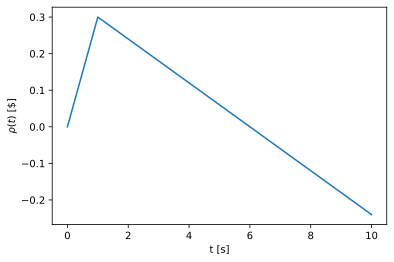

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml


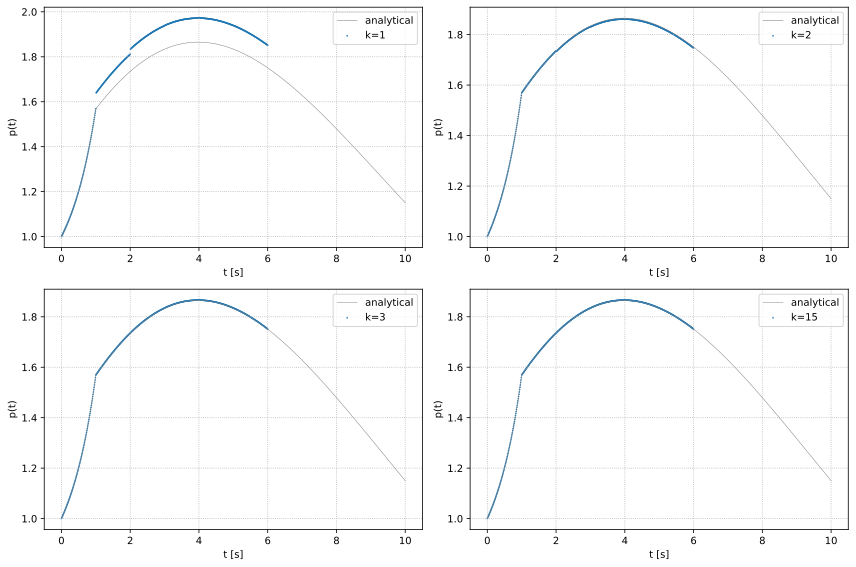

In [120]:
lambduh_list = np.asarray([p.decay_constant for p in params.precursors])
t_analytical = np.linspace(0,10,1001)

rho_imp = generate_rho_imp(t_analytical, t1, up, down)

plt.plot(t_analytical, rho_imp)
plt.xlabel('t [s]')
plt.ylabel('$\\rho(t)$ [\$]')
plt.savefig('parareal_ramp_reactivity.pdf')
plt.show()
plt.show()

p_analytical = analytic_soln(lambduh_list, t_analytical, t1, up, down, 1.0)

fig, axes = plt.subplots(2,2,figsize=(12,8))

initial_coarse_output = run_parareal(params, precomp)
coarse_t_out = initial_coarse_output.time
coarse_p_out = initial_coarse_output.power * initial_coarse_output.pow_norm

max_iter_list = [1,2,3,15]
for i in range(len(max_iter_list)):
    params.max_iter = max_iter_list[i]
    params.n_fine_per_coarse = 100
    updated_output = run_parareal(params, precomp)
    
    updated_t_out = updated_output.time
    updated_p_out = updated_output.power * updated_output.pow_norm

    ax = axes.flatten()[i]
    
    ax.plot(t_analytical, p_analytical, color=(0.5, 0.5, 0.5), linewidth=0.5, label='analytical')
    #ax.scatter(coarse_t_out, coarse_p_out, label='original coarse',marker='x')
    ax.scatter(updated_t_out, updated_p_out, marker='+', 
               label='k='+str(params.max_iter),
               s=1.0)
    #ax.set_ylim(0.95, 4.75)
    ax.set_xlabel('t [s]')
    ax.set_ylabel('p(t)')
    ax.legend(loc=0)
    ax.grid(linestyle=':')
plt.tight_layout()
plt.savefig('parareal_example.pdf')
plt.show()

In [ ]:
lambduh_list = np.asarray([p.decay_constant for p in params.precursors])
t_analytical = np.linspace(0,6,601)

rho_imp = generate_rho_imp(t_analytical, t1, up, down)

plt.plot(t_analytical, rho_imp)
plt.xlabel('t [s]')
plt.ylabel('$\\rho(t)$ [\$]')
plt.savefig('parareal_ramp_reactivity.pdf')
plt.show()
plt.show()

p_analytical = analytic_soln(lambduh_list, t_analytical, t1, up, down, 1.0)

fig, axes = plt.subplots(2,2,figsize=(12,8))

initial_coarse_output = run_parareal(params, precomp)
coarse_t_out = initial_coarse_output.time
coarse_p_out = initial_coarse_output.power * initial_coarse_output.pow_norm

max_iter_list = [1,2,3,4]
for i in range(len(max_iter_list)):
    params.max_iter = max_iter_list[i]
    params.n_fine_per_coarse = 100
    updated_output = run_parareal(params, precomp)
    
    updated_t_out = updated_output.time
    updated_p_out = updated_output.power * updated_output.pow_norm
    updated_concentrations_out = updated_output.concentrations
    
    ax = axes.flatten()[i]
    
    #ax.plot(t_analytical, p_analytical, color=(0.5, 0.5, 0.5), linewidth=0.5, label='analytical')
    #ax.scatter(coarse_t_out, coarse_p_out, label='original coarse',marker='x')
    for j in range(len(updated_concentrations_out)):
        ax.scatter(updated_t_out, updated_concentrations_out[j], marker='+', 
                   label='k='+str(params.max_iter),
                   s=1.0)
    #ax.set_ylim(0.95, 4.75)
    ax.set_xlabel('t [s]')
    ax.set_ylabel('$\zeta$(t)')
    ax.legend(loc=0)
    ax.grid(linestyle=':')
plt.tight_layout()
plt.savefig('parareal_ramp_concentrations.pdf')
plt.show()

In [23]:
def run_serial(delta_t):
    # Generate time vector
    t_end = 6
    t = np.linspace(0,t_end,int(t_end/delta_t)+1)
    
    # Generate precursors
    precursors = [Precursor(0.49405, 0.0076)]
    beta_sum = sum([p.beta for p in precursors])
    
    # Generate rho imp vector
    up = .5 # $/s (upwards reactivity ramp)
    down = .1 # $/s (downwards reactivity ramp)
    t1 = 1
    rho_imp = generate_rho_imp(t,t1,up,down)
    
    beta_eff = beta_sum * np.ones(len(t))
    rho_imp = rho_imp * beta_sum
    gen_time = 2.6e-15 * np.ones(len(t))
    lambduh_h = np.ones(len(t))
    pow_norm = np.ones(len(t))
    theta = 1.0
    eta = 1.0
    gamma_d = 0.0
    n_fine_per_coarse = 1
    max_iter = 0
    
    # Create parameters object
    params = Params(t, rho_imp, precursors, lambduh_h, gen_time, 
                    pow_norm, beta_eff, theta, gamma_d, 
                    eta, max_iter, n_fine_per_coarse)
    
    # Generate the initial conditions
    precomp_time = [0.0]
    precomp_power = [1.0]
    precomp_pow_norm = [1.0]
    precomp_rho = [rho_imp[0]]
    precomp_concentrations = []
    
    for j, precursor in enumerate(precursors):
        initial_concentration = precursor.beta*precomp_power[0]/precursor.decay_constant
        precomp_concentrations.append([initial_concentration])
    
    # Create precomputed values object
    precomp = Precomp(precomp_time, precomp_power, precomp_pow_norm, precomp_rho, precomp_concentrations)

    output = run_parareal(params, precomp)
    
    return output

serial_output = run_serial(0.001)

print(serial_output.solve_time)

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
0.019255


In [29]:
def generate_input_file(coarse_delta_t):
    # Generate time vector
    t_end = 6
    delta_t = coarse_delta_t # number of time steps per second
    t = np.linspace(0,t_end,int(t_end/delta_t)+1)
    
    # Generate precursors
    precursors = [Precursor(0.49405, 0.0076)]
    beta_sum = sum([p.beta for p in precursors])
    
    # Generate rho imp vector
    up = .5 # $/s (upwards reactivity ramp)
    down = .1 # $/s (downwards reactivity ramp)
    t1 = 1
    rho_imp = generate_rho_imp(t,t1,up,down)
    
    beta_eff = beta_sum * np.ones(len(t))
    rho_imp = rho_imp * beta_sum
    gen_time = 2.6e-15 * np.ones(len(t))
    lambduh_h = np.ones(len(t))
    pow_norm = np.ones(len(t))
    theta = 1.0
    eta = 1.0
    gamma_d = 0.0
    n_fine_per_coarse = 1
    max_iter = 1
    
    # Create parameters object
    params = Params(t, rho_imp, precursors, lambduh_h, gen_time, 
                    pow_norm, beta_eff, theta, gamma_d, 
                    eta, max_iter, n_fine_per_coarse)
    
    # Generate the initial conditions
    precomp_time = [0.0]
    precomp_power = [1.0]
    precomp_pow_norm = [1.0]
    precomp_rho = [rho_imp[0]]
    precomp_concentrations = []
    
    for j, precursor in enumerate(precursors):
        initial_concentration = precursor.beta*precomp_power[0]/precursor.decay_constant
        precomp_concentrations.append([initial_concentration])
    
    # Create precomputed values object
    precomp = Precomp(precomp_time, precomp_power, precomp_pow_norm, precomp_rho, precomp_concentrations)
    
    return params, precomp

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing 

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml
Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing 

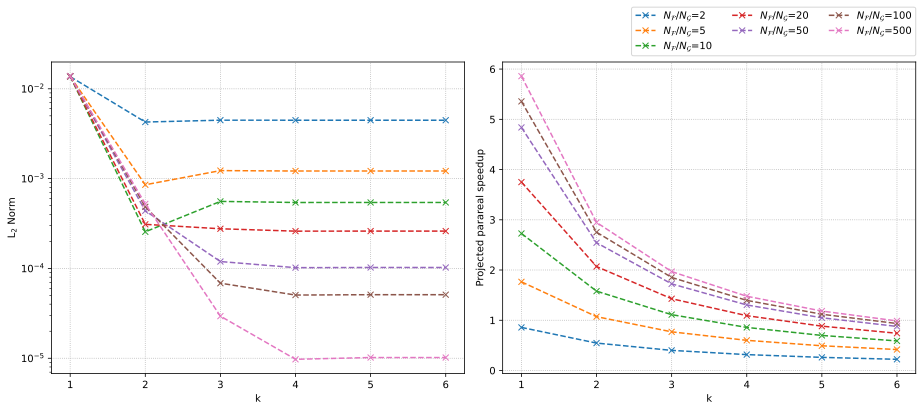

In [88]:
from matplotlib.ticker import MaxNLocator

lambduh_list = np.asarray([p.decay_constant for p in params.precursors])
t_analytical = np.linspace(0,6,601)

rho_imp = generate_rho_imp(t_analytical, t1, up, down)

p_analytical = analytic_soln(lambduh_list, t_analytical, t1, up, down, 1.0)

coarse_delta_t = 1.0
params, precomp = generate_input_file(coarse_delta_t)
initial_coarse_output = run_parareal(params, precomp)
coarse_t_out = initial_coarse_output.time
coarse_p_out = initial_coarse_output.power * initial_coarse_output.pow_norm

max_iter_list = [1,2,3,4,5,6]
ratio_list = [2,5,10,20,50,100,500]

norm_list = np.zeros((len(ratio_list),len(max_iter_list)))
time_list = np.zeros((len(ratio_list),len(max_iter_list)))

for r, ratio in enumerate(ratio_list):    
    for i in range(len(max_iter_list)):
        params.max_iter = max_iter_list[i]
        params.n_fine_per_coarse = ratio_list[r]
        updated_output = run_parareal(params, precomp)
        serial_output = run_serial(coarse_delta_t/n_fine_per_coarse)
        
        updated_t_out = updated_output.time
        updated_p_out = updated_output.power * updated_output.pow_norm
        
        interp_analytical = np.interp(t_analytical,updated_t_out,updated_p_out)
        norm_list[r][i] = np.linalg.norm(interp_analytical-p_analytical)/len(p_analytical)
        time_list[r][i] = serial_output.solve_time / (serial_output.solve_time * ((i+2) / ratio + (i+1)/(6)))

fig, axes = plt.subplots(1,2,figsize=(13,6))
for r in range(len(norm_list)):
    axes[0].plot(np.arange(1,len(max_iter_list)+1),norm_list[r],marker='x',
                 linestyle='--',
                 label='$N_{\mathcal{F}} / N_{\mathcal{G}}$='+str(ratio_list[r]))
    axes[1].plot(np.arange(1,len(max_iter_list)+1),time_list[r],marker='x',
                 linestyle='--',
                 label='$N_{\mathcal{F}} / N_{\mathcal{G}}$='+str(ratio_list[r]))
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_xlabel('k')
axes[0].grid(linestyle=':')
axes[0].set_yscale('log')
axes[0].set_ylabel('L$_2$ Norm')
axes[1].set_xlabel('k')
#axes[1].set_yscale('log')
axes[1].grid(linestyle=':')
axes[1].set_ylabel('Projected parareal speedup')
plt.legend(loc="lower right", bbox_to_anchor=(1., 1.02) , borderaxespad=0., ncol=3)
plt.tight_layout()
plt.savefig('reactivity_ramp_convergence.pdf')
plt.show()